In [60]:
import keras
import numpy as np
import my_models
import keras.preprocessing.text
import torch
from torch.autograd import Variable
import time
import copy
import random
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

import numpy as np
%matplotlib inline



In [2]:
cocoqa_train_q = np.genfromtxt("cocoqa/train/questions.txt", dtype = str, delimiter='\n')
cocoqa_test_q = np.genfromtxt("cocoqa/test/questions.txt", dtype = str, delimiter='\n')

# split sentences into words
tokenizer = keras.preprocessing.text.Tokenizer(filters = '!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n')
tokenizer.fit_on_texts(cocoqa_train_q)
tokenizer.fit_on_texts(cocoqa_test_q)

# conver sentences into sequences of word ids
sequences_train_q = tokenizer.texts_to_sequences(cocoqa_train_q)
sequences_test_q = tokenizer.texts_to_sequences(cocoqa_test_q)


word2id_q = tokenizer.word_index
id2word_q = {idx: word for (word, idx) in word2id_q.items()}
vocab_size = len(word2id_q)

maxSequenceLength = max([len(seq) for seq in sequences_train_q + sequences_train_q])


cocoqa_train_a = np.genfromtxt("cocoqa/train/answers.txt", dtype = str)
cocoqa_test_a = np.genfromtxt("cocoqa/test/answers.txt", dtype = str)
# split sentences into words
tokenizer = keras.preprocessing.text.Tokenizer(filters = '!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n')
tokenizer.fit_on_texts(cocoqa_train_a)
tokenizer.fit_on_texts(cocoqa_test_a)
# conver sentences into sequences of word ids
sequences_train_a = tokenizer.texts_to_sequences(cocoqa_train_a)
sequences_test_a = tokenizer.texts_to_sequences(cocoqa_test_a)
# print(sequences_train_a[0])
# print(cocoqa_train_a[0])

word2id_a = tokenizer.word_index
id2word_a = {idx: word for (word, idx) in word2id_a.items()}
# maxSequenceLength = max([len(seq) for seq in captionSequences])
a_size = len(word2id_a)
# print(a_size)

# print(id2word_a[0])
# print(id2word_a[a_size])

# load image features
train_features = torch.load('features/train_features_SAN_0.pth')
test_features = torch.load('features/val_features_SAN_0.pth')

val_image_indices = np.genfromtxt('cocoqa/test/img_ids.txt', dtype=int)
train_image_indices = np.genfromtxt('cocoqa/train/img_ids.txt', dtype=int)

In [3]:
img_embed = torch.load('models2/04-20/img_embed.pth')
word_embed = torch.load('models2/04-20/word_embed.pth')
lstm = torch.load('models2/04-20/lstm.pth')
classifier = torch.load('models2/04-20/classifier.pth')

In [3]:
models = {}
models['feature_trans'] = torch.load('05-01/feature_trans.pth')
models['word_embed'] = torch.load('05-01/word_embed.pth')
models['lstm'] = torch.load('05-01/lstm.pth')
models['atten1'] = torch.load('05-01/atten1.pth')
models['atten2'] = torch.load('05-01/atten2.pth')
models['classifier'] = torch.load('05-01/classifier.pth')

In [111]:
model_dict = models
train_or_val_size = 0
def test_result(tr_or_val, index):
    if tr_or_val == "train":
        question_txt = cocoqa_train_q
        features = train_features
        questions = sequences_train_q
        answers = sequences_train_a
        img_idx = train_image_indices[index]
    elif tr_or_val == "val":
        question_txt = cocoqa_test_q
        features = test_features
        questions = sequences_test_q
        answers = sequences_test_a
        img_idx = val_image_indices[index]
        
    for key in model_dict.keys():
        model_dict[key].train(False)  # Set model to evaluate mode
    
    current_f = features[index]
    current_q = torch.LongTensor(questions[train_or_val_size + index])
    # Note: here I -1 because keras tokenizer does not has word with id 0
    current_a = torch.LongTensor([answers[train_or_val_size + index][0] - 1])


    # wrap them in Variable
    current_f, current_q, current_a = Variable(current_f.cuda()), Variable(current_q.cuda()), Variable(current_a.cuda())

    FI = current_f
    V_I = model_dict['feature_trans'](FI)

    Q_embed = model_dict['word_embed'](current_q)



    hidden = (torch.autograd.Variable(torch.zeros(1, 1, 1024)).cuda(),
            torch.autograd.Variable(torch.zeros(1, 1, 1024)).cuda())

    lstm_output, hidden = model_dict['lstm'](Q_embed.view(len(Q_embed), 1, -1), hidden)

    V_Q = lstm_output[-1].view(1, 1024)

    # stack 1
    p = model_dict['atten1'](V_I, V_Q)
    # print(p)
    V_I_next = torch.mm(p, V_I)
    V_Q = V_I_next + V_Q

    # stack 2
    p = model_dict['atten2'](V_I, V_Q)
    # print(p)

    V_I_next = torch.mm(p, V_I)
    V_Q = V_I_next + V_Q

    class_score = model_dict['classifier'](V_Q)
    _, preds = torch.max(class_score.data, 1)
    
    img_path = "{s}2014/COCO_{s}2014_{d:012d}.jpg".format(s=tr_or_val, d=img_idx,)


    img = Image.open(img_path).convert('RGB')
    
    fig, ax = plt.subplots()
    ax.imshow(img, aspect='auto')
    ax.axis('off')
    plt.show()
    print("   Image id: {}".format(img_idx))
    print("   Question: {}".format(question_txt[index]))
    print("   Correct Answer: {}".format(id2word_a[answers[index][0]]))
    print("   Prediction: {}".format(id2word_a[1 + int(torch.Tensor.sum(preds.cpu().float()))]))
    
    im = img
    w, h = im.size
    im = im.resize((int(w*448.0/h), 448))
    w, h = im.size


    left = (w - 448)/2
    top = (h - 448)/2
    right = (w + 448)/2
    bottom = (h + 448)/2
    im = im.crop((left, top, right, bottom))

    fig=plt.figure()
    ax=fig.add_subplot(111)

    myInterval=14.
    loc = plticker.MultipleLocator(base=myInterval)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)

    ax.grid(which='major', axis='both', linestyle='-')

    ax.imshow(im)

    # Find number of gridsquares in x and y direction
    nx=abs(int(float(ax.get_xlim()[1]-ax.get_xlim()[0])/float(myInterval)))
    ny=abs(int(float(ax.get_ylim()[1]-ax.get_ylim()[0])/float(myInterval)))

    min = torch.min(p)
    print (min)
    # Add some labels to the gridsquares
    for j in range(14):
        y=myInterval/2+j*myInterval
        for i in range(14):
            if (p.data[0][j * 14 + i] >= min):
                x=myInterval/2.+float(i)*myInterval
                ax.text(x,y,'X',color='w',ha='center',va='center')

    plt.imshow(im);
        

2963


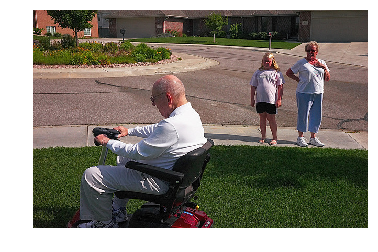

   Image id: 232511
   Question: what does the man drive
   Correct Answer: scooter
   Prediction: bicycle
Variable containing:
1.00000e-03 *
  2.7916
[torch.cuda.FloatTensor of size 1 (GPU 0)]



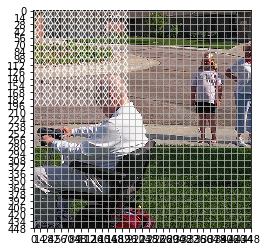

In [112]:
index = random.randint(0, 5000)
print(index)
test_result("val", 4418)

In [5]:
def test_result(tr_or_val, index):
    if tr_or_val == "train":
        question_txt = cocoqa_train_q
        features = train_features
        questions = sequences_train_q
        answers = sequences_train_a
        img_idx = train_image_indices[index]
    elif tr_or_val == "val":
        question_txt = cocoqa_test_q
        features = test_features
        questions = sequences_test_q
        answers = sequences_test_a
        img_idx = val_image_indices[index]

    current_f = features[index].view(1,-1)
    current_q = torch.LongTensor(questions[index])
    current_a = torch.LongTensor([answers[index][0] - 1])

    current_f, current_q, current_a = Variable(current_f.cuda()), Variable(current_q.cuda()), Variable(current_a.cuda())


    i_embedding = img_embed(current_f)

    w_embedding = word_embed(current_q)

    lstm_input = torch.Tensor(w_embedding.size(0), w_embedding.size(1) + i_embedding.size(1))
    for idx, w_embedding_i in enumerate(w_embedding):
        lstm_input[idx] = torch.cat((w_embedding_i, i_embedding[0]), 0).data
    lstm_input = Variable(lstm_input)

    lstm.init_hidden_cuda()
    lstm_input = lstm_input.cuda()

    output = lstm(lstm_input.view(len(lstm_input), 1, -1))

    class_score = classifier(output[-1])
    _, preds = torch.max(class_score.data, 1)

    img_path = "{s}2014/COCO_{s}2014_{d:012d}.jpg".format(s=tr_or_val, d=img_idx,)


    img = Image.open(img_path).convert('RGB')
    
    fig, ax = plt.subplots()

    ax.imshow(img, aspect='auto')
    ax.axis('off')
    plt.show()
    print("   Image id: {}".format(img_idx))
    print("   Question: {}".format(question_txt[index]))
    print("   Correct Answer: {}".format(id2word_a[answers[index][0]]))
    print("   Prediction: {}".format(id2word_a[1 + int(torch.Tensor.sum(preds.cpu().float()))]))
    
#     fig, ax = plt.subplots()
#     ax.imshow(image)
#     ax.axis('off')  # clear x- and y-axes
#     plt.show()

In [ ]:
298762
198486
571437
359303  -  2 plane 
529215
346412

72011 - 21714

4281


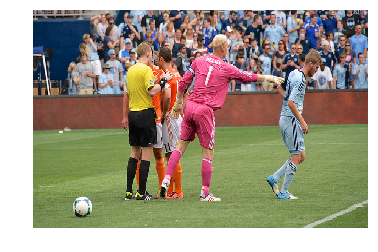

   Image id: 372024
   Question: how many soccer players is taking a brief time out
   Correct Answer: five
   Prediction: two


In [15]:
index = random.randint(0, 40000)
print(index)
test_result("val", index)

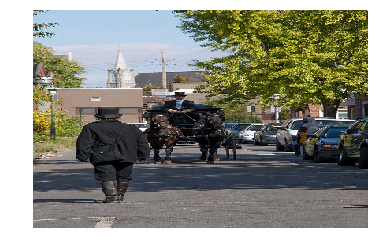

   Image id: 298762
   Question: two horses pulling what down the road
   Correct Answer: carriage
   Prediction: carriage


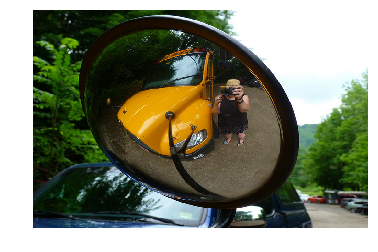

   Image id: 198486
   Question: where does the person take a selfie
   Correct Answer: mirror
   Prediction: mirror


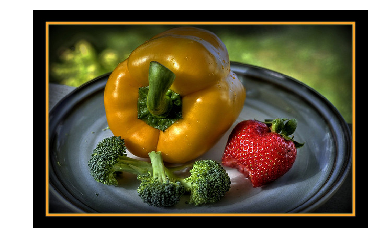

   Image id: 571437
   Question: what topped with the mix of vegetables and fruit
   Correct Answer: plate
   Prediction: plate


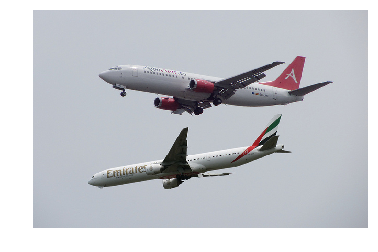

   Image id: 359303
   Question: what are flying in an open sky
   Correct Answer: airplanes
   Prediction: airplanes


In [47]:
index = random.randint(0, 40000)
test_result("val", 9379)
test_result("val", 25524)
test_result("val", 6242)
test_result("val", 32130)

In [72]:
models = {}
models['feature_trans'] = torch.load('models3/04-24/feature_trans.pth')
models['word_embed'] = torch.load('models3/04-24/word_embed.pth')
models['lstm'] = torch.load('models3/04-24/lstm.pth')
models['atten1'] = torch.load('models3/04-24/atten1.pth')
models['atten2'] = torch.load('models3/04-24/atten2.pth')
models['classifier'] = torch.load('models3/04-24/classifier.pth')

In [73]:
part = 1
features = torch.load('features/train_features_SAN_%d.pth'%(part))
questions = sequences_train_q
answers = sequences_train_a

In [145]:
import torch.autograd as autograd
import torch.nn as nn
import my_models

models = {}
models['feature_trans'] = (my_models.FeatureTransfer(512, 1024))
models['word_embed'] = (my_models.WordEmbedding2(vocab_size + 1, 500))
models['lstm'] = (nn.LSTM(500, 1024))
models['atten1'] = (Attention(1024, 512))
models['atten2'] = (Attention(1024, 512))
models['classifier'] = (my_models.Classifier(1024, a_size))

for key in models.keys():
    models[key].cuda()
model_dict = models

    
i = 100
train_or_val_size = 0
current_f = features[i]
current_q = torch.LongTensor(questions[train_or_val_size + i])
# Note: here I -1 because keras tokenizer does not has word with id 0
current_a = torch.LongTensor([answers[train_or_val_size + i][0] - 1])
current_f, current_q, current_a = Variable(current_f.cuda()), Variable(current_q.cuda()), Variable(current_a.cuda())
FI = current_f
V_I = model_dict['feature_trans'](FI)
# print(V_I)
Q_embed = model_dict['word_embed'](current_q)
hidden = (autograd.Variable(torch.zeros(1, 1, 1024)).cuda(),
        autograd.Variable(torch.zeros(1, 1, 1024)).cuda())

lstm_output, hidden = model_dict['lstm'](Q_embed.view(len(Q_embed), 1, -1), hidden)

# int(lstm_output[-1])
V_Q = lstm_output[-1].view(1, 1024)

p = model_dict['atten1'](V_I, V_Q)
print(p.size())
temp_x = V_I[:,0]
V_I_next = torch.mm(p, V_I)

V_Q = V_I_next + V_Q

torch.Size([1, 196])


In [156]:
import numpy as np
x = torch.Tensor(np.ones((10, 20)))
p = torch.Tensor([0.1*y for y in range(10)]).view(1, -1)
print( torch.mm(p, x))




Columns 0 to 9 
 4.5000  4.5000  4.5000  4.5000  4.5000  4.5000  4.5000  4.5000  4.5000  4.5000

Columns 10 to 19 
 4.5000  4.5000  4.5000  4.5000  4.5000  4.5000  4.5000  4.5000  4.5000  4.5000
[torch.FloatTensor of size 1x20]



In [116]:
import torch.nn.functional as F
class Attention(nn.Module):
    def __init__(self, input_size, atten_size):
        super(Attention, self).__init__()
        self.ln1 = nn.Linear(input_size, atten_size)

        self.ln2 = nn.Linear(input_size, atten_size, bias=False)
        self.drop = nn.Dropout(0.5)
        self.ln3 = nn.Linear(atten_size, 1)
    def forward(self, V_I, V_Q):
        x1 = self.ln1(V_Q)
        x2 = self.ln2(V_I)
        # print(x1)
        # print(x2)

        for x_temp in range(x2.size(0)):
            x2.data[x_temp] = x2.data[x_temp] + x1.data[0]
        # print(x2.data[0])
        h_a = self.drop(F.tanh(x2))   # [196 * 512(k)]
        # print(h_a)

        h_a.view(-1, 512)
        # print(h_a)
        p = F.softmax(self.ln3(h_a).view(-1, 196))

        return p